# Evaluating Survival Models

The most frequently used evaluation metric of survival models is the concordance index (c index, c statistic). It is a measure of rank correlation between predicted risk scores $\hat{f}$ and observed time points $y$ that is closely related to [Kendall’s τ](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient). It is defined as the ratio of correctly ordered (concordant) pairs to comparable pairs.
Two samples $i$ and $j$ are comparable if the sample with lower observed time $y$ experienced an event, i.e., if $y_j > y_i$ and $\delta_i = 1$, where $\delta_i$ is a binary event indicator. A comparable pair $(i, j)$ is concordant if the estimated risk $\hat{f}$ by a survival model  is higher for subjects with lower survival time, i.e., $\hat{f}_i > \hat{f}_j \land y_j > y_i$, otherwise the pair is discordant.
Harrell's estimator of the c index is implemented in [concordance_index_censored](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.metrics.concordance_index_censored.html#sksurv.metrics.concordance_index_censored).

While Harrell's concordance index is easy to interpret and compute, it has some shortcomings:
1. it has been shown that it is too optimistic with increasing amount of censoring [[1]](https://dx.doi.org/10.1002/sim.4154),
2. it is not a useful measure of performance if a specific time range is of primary interest (e.g. predicting death within 2 years).

Since version 0.8, scikit-survival supports an alternative estimator of the concordance
index from right-censored survival data, implemented in [concordance_index_ipcw](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.metrics.concordance_index_ipcw.html#sksurv.metrics.concordance_index_ipcw), that addresses the first issue.

The second point can be addressed by extending the well known receiver operating characteristic curve (ROC curve) to possibly censored survival times. Given a time point $t$, we can estimate how well a predictive model can distinguishing subjects who will experience an event by time $t$ (sensitivity) from those who will not (specificity). The function [cumulative_dynamic_auc](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.metrics.cumulative_dynamic_auc.html#sksurv.metrics.cumulative_dynamic_auc) implements an estimator of the cumulative/dynamic area under the ROC for a given list of time points.

The [first part](#Bias-of-Harrell's-Concordance-Index) of this notebook will illustrate the first issue with simulated survival data, while the [second part](#Time-dependent-Area-under-the-ROC) will focus on the time-dependent area under the ROC applied to data from a real study.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sksurv.datasets import load_flchain
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

plt.rcParams['figure.figsize'] = [7.2, 4.8]

## Bias of Harrell's Concordance Index

Harrell's concordance index is known to be biased upwards if the amount of censoring in the test data is high [[1]](https://dx.doi.org/10.1002/sim.4154). [Uno et al](https://dx.doi.org/10.1002/sim.4154) proposed an alternative estimator of the concordance index that behaves better in such situations.
In this section, we are going to apply [concordance_index_censored](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.metrics.concordance_index_censored.html#sksurv.metrics.concordance_index_censored)
and [concordance_index_ipcw](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.metrics.concordance_index_ipcw.html#sksurv.metrics.concordance_index_ipcw) to synthetic survival data and compare their results.

### Simulation Study

We are generating a synthetic biomarker by sampling from a standard normal distribution. For a given hazard ratio, we compute the associated (actual) survival time by drawing from an exponential distribution. The censoring times were generated from a uniform independent distribution $\textrm{Uniform}(0,\gamma)$, where we choose $\gamma$ to produce different amounts of censoring.

Since Uno's estimator is based on inverse probability of censoring weighting, we need to estimate the probability of being censored at a given time point. This probability needs to be non-zero for all observed time points. Therefore, we restrict the test data to all samples with observed time lower than the maximum event time $\tau$. Usually, one would use the `tau` argument of `concordance_index_ipcw` for this, but we apply the selection before to pass identical inputs to `concordance_index_censored` and `concordance_index_ipcw`.
The estimates of the concordance index are therefore restricted to the interval $[0, \tau]$.

In [2]:
import scipy.optimize as opt


def generate_marker(n_samples,
                    hazard_ratio,
                    baseline_hazard,
                    rnd):
    # create synthetic risk score
    X = rnd.randn(n_samples, 1)

    # create linear model
    hazard_ratio = np.array([hazard_ratio])
    logits = np.dot(X, np.log(hazard_ratio))

    # draw actual survival times from exponential distribution,
    # refer to Bender et al. (2005), https://doi.org/10.1002/sim.2059
    u = rnd.uniform(size=n_samples)
    time_event = -np.log(u) / (baseline_hazard * np.exp(logits))

    # compute the actual concordance in the absence of censoring
    X = np.squeeze(X)
    actual = concordance_index_censored(np.ones(n_samples, dtype=bool),
                                        time_event, X)
    return X, time_event, actual[0]
    

def generate_survival_data(n_samples,
                           hazard_ratio,
                           baseline_hazard,
                           percentage_cens,
                           rnd):
    X, time_event, actual_c = generate_marker(n_samples, hazard_ratio,
                                              baseline_hazard, rnd)

    def get_observed_time(x):
        rnd_cens = np.random.RandomState(0)
        # draw censoring times
        time_censor = rnd_cens.uniform(high=x, size=n_samples)
        event = time_event < time_censor
        time = np.where(event, time_event, time_censor)
        return event, time
  
    def censoring_amount(x):
        event, _ = get_observed_time(x)
        cens = 1.0 - event.sum() / event.shape[0]
        return (cens - percentage_cens)**2

    # search for upper limit to obtain the desired censoring amount
    res = opt.minimize_scalar(censoring_amount,
                              method="bounded",
                              bounds=(0, time_event.max()))

    # compute observed time
    event, time = get_observed_time(res.x)

    # upper time limit such that the probability
    # of being censored is non-zero for `t > tau`
    tau = time[event].max()
    y = Surv.from_arrays(event=event, time=time)
    mask = time < tau
    X_test = X[mask]
    y_test = y[mask]

    return X_test, y_test, y, actual_c


def simulation(n_samples, hazard_ratio, n_repeats=100):
    measures = ("censoring", "Harrel's C", "Uno's C",)
    data_mean = {}
    data_std = {}
    for measure in measures:
        data_mean[measure] = []
        data_std[measure] = []

    rnd = np.random.RandomState(seed=987)
    # iterate over different amount of censoring
    for cens in (.1, .25, .4, .5, .6, .7):
        data = {"censoring": [], "Harrel's C": [], "Uno's C": [],}

        # repeaditly perform simulation
        for _ in range(n_repeats):
            # generate data
            X_test, y_test, y_train, actual_c = generate_survival_data(
                n_samples, hazard_ratio,
                baseline_hazard=0.1,
                percentage_cens=cens,
                rnd=rnd)

            # estimate c-index
            c_harrell = concordance_index_censored(y_test["event"], y_test["time"], X_test)
            c_uno = concordance_index_ipcw(y_train, y_test, X_test)

            # save results
            data["censoring"].append(100. - y_test["event"].sum() * 100. / y_test.shape[0])
            data["Harrel's C"].append(actual_c - c_harrell[0])
            data["Uno's C"].append(actual_c - c_uno[0])

        # aggregate results
        for key, values in data.items():
            data_mean[key].append(np.mean(data[key]))
            data_std[key].append(np.std(data[key], ddof=1))

    data_mean = pd.DataFrame.from_dict(data_mean)
    data_std = pd.DataFrame.from_dict(data_std)
    return data_mean, data_std


def plot_results(data_mean, data_std, **kwargs):
    index = pd.Index(data_mean["censoring"].round(3), name="mean percentage censoring")
    for df in (data_mean, data_std):
        df.drop("censoring", axis=1, inplace=True)
        df.index = index

    ax = data_mean.plot.bar(yerr=data_std, **kwargs)
    ax.set_ylabel("Actual C - Estimated C")
    ax.yaxis.grid(True)
    ax.axhline(0.0, color="gray")

Let us assume a moderate hazard ratio of 2 and generate a small synthetic dataset of 100 samples from which we estimate the concordance index. We repeat this experiment 200 times and plot mean and standard deviation of the difference between the *actual* (in the absence of censoring) and *estimated* concordance index.

Since the hazard ratio remains constant and only the amount of censoring changes, we would want an estimator for which the difference between the actual and estimated c to remain approximately constant across simulations.

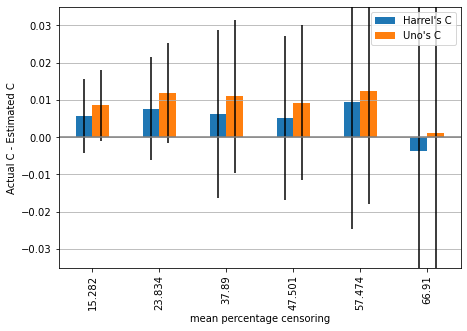

In [3]:
hazard_ratio = 2.0
ylim = [-0.035, 0.035]
mean_1, std_1 = simulation(100, hazard_ratio)
plot_results(mean_1, std_1, ylim=ylim)

We can observe that estimates are on average below the actual value, except for the highest amount of censoring, where Harrell's c begins overestimating the performance (on average).

With such a small dataset, the variance of differences is quite big, so let us increase the amount of data to 1000 and repeat the simulation (*this may take some time*).

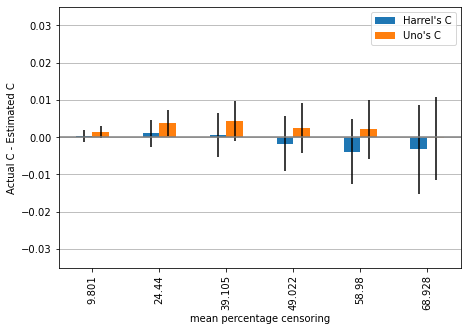

In [4]:
mean_2, std_2 = simulation(1000, hazard_ratio)
plot_results(mean_2, std_2, ylim=ylim)

Now we can observe that Harrell's c begins to overestimate performance starting with approximately 49% censoring while Uno's c is still underestimating the performance, but is on average very close to the actual performance for large amounts of censoring.

For the final experiment, we double the size of the dataset to 2000 samples and repeat the analysis (*this may take several minutes to compute*).

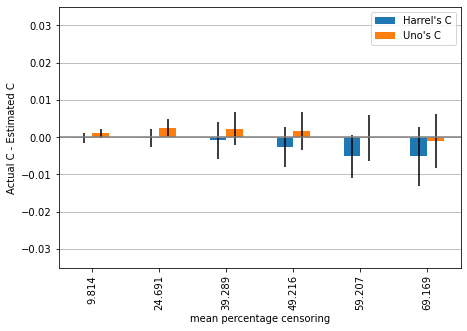

In [5]:
mean_3, std_3 = simulation(2000, hazard_ratio)
plot_results(mean_3, std_3, ylim=ylim)

The trend we observed in the previous simulation is now even more pronounced.
Harrell's c is becoming more and more overconfident in the performance of the synthetic marker with increasing amount of censoring, while Uno's c remains stable.

In summary, while the difference between [concordance_index_ipcw](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.metrics.concordance_index_ipcw.html#sksurv.metrics.concordance_index_ipcw)
and [concordance_index_censored](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.metrics.concordance_index_censored.html#sksurv.metrics.concordance_index_censored) is negligible for small amounts of censoring, when analyzing survival data with moderate to high amounts of censoring, you might want to consider estimating the performance using `concordance_index_ipcw` instead of `concordance_index_censored`.

## Time-dependent Area under the ROC

The area under the [receiver operating characteristics curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC curve) is a popular performance measure for binary classification task. In the medical domain, it is often used to determine how well estimated risk scores can separate diseased patients (cases) from healthy patients (controls). Given a predicted risk score $\hat{f}$, the ROC curve compares the false positive rate (1 - specificity) against the true positive rate (sensitivity) for each possible value of $\hat{f}$.

When extending the ROC curve to continuous outcomes, in particular survival time, a patient’s disease status is typically not fixed and changes over time: at enrollment a subject is usually healthy, but may be diseased at some later time point. Consequently, sensitivity and specificity become [time-dependent measures](http://dx.doi.org/10.1111/j.0006-341x.2000.00337.x).
Here, we consider *cumulative cases* and *dynamic controls* at a given time point $t$, which gives rise to the time-dependent cumulative/dynamic ROC at time $t$.
Cumulative cases are all individuals that experienced an event prior to or at time $t$ ($t_i 
\leq t$), whereas dynamic controls are those with $t_i>t$.
By computing the area under the cumulative/dynamic ROC at time $t$, we can determine how well a model can distinguish subjects who fail by a given time ($t_i \leq t$) from subjects who fail after this time ($t_i>t$).
Hence, it is most relevant if one wants to predict the occurrence of an event in a period up to time $t$ rather than at a specific time point $t$.

The [cumulative_dynamic_auc](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.metrics.cumulative_dynamic_auc.html#sksurv.metrics.cumulative_dynamic_auc) function implements an estimator of the cumulative/dynamic area under the ROC at a given list of time points.
To illustrate its use, we are going to use data from a [study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3538473/) that investigated to which extent the serum immunoglobulin free light chain (FLC) assay can be used predict overall survival. The dataset has 7874 subjects and 9 features; the endpoint is death, which occurred for 2169 subjects (27.5%).

First, we are loading the data and split it into train and test set to evaluate how well markers generalize.

In [6]:
x, y = load_flchain()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Serum creatinine measurements are missing for some patients, therefore we are just going to impute these values with the mean using scikit-learn's `SimpleImputer`.

In [7]:
num_columns = ['age', 'creatinine', 'kappa', 'lambda']

imputer = SimpleImputer().fit(x_train.loc[:, num_columns])
x_train = imputer.transform(x_train.loc[:, num_columns])
x_test = imputer.transform(x_test.loc[:, num_columns])

Similar to Uno's estimator of the concordance index described above, we need to be a little bit careful when selecting the test data and time points we want to evaluate the ROC at, due to the estimator's dependence on inverse probability of censoring weighting.
First, we are going to check whether the observed time of the test data lies within the observed time range of the training data.

In [8]:
y_events = y_train[y_train['death']]
train_min, train_max = y_events["futime"].min(), y_events["futime"].max()

y_events = y_test[y_test['death']]
test_min, test_max = y_events["futime"].min(), y_events["futime"].max()

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

When choosing the time points to evaluate the ROC at, it is important to remember to choose the last time point such that the probability of being censored after the last time point is non-zero. In the simulation study above, we set the upper bound to the maximum event time, here we use a more conservative approach by setting the upper bound to the 80% percentile of observed time points, because the censoring rate is quite large at 72.5%.
Note that this approach would be appropriate for choosing `tau` of  [concordance_index_ipcw](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.metrics.concordance_index_ipcw.html#sksurv.metrics.concordance_index_ipcw) too.

In [9]:
times = np.percentile(y["futime"], np.linspace(5, 81, 15))
print(times)

[ 470.3        1259.         1998.         2464.82428571 2979.
 3401.         3787.99857143 4051.         4249.         4410.17285714
 4543.         4631.         4695.         4781.         4844.        ]


We begin by considering individual real-valued features as risk scores without actually fitting a survival model. Hence, we obtain an estimate of how well *age*, *creatinine*, *kappa* FLC, and *lambda* FLC are able to distinguish cases from controls at each time point.

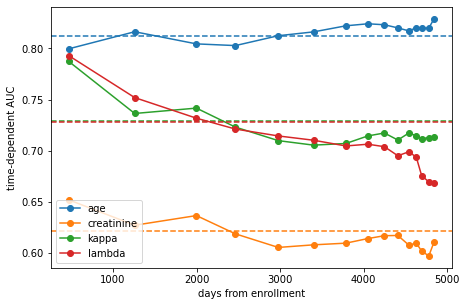

In [10]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()

    
for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(x_test[:, i], col, color="C{}".format(i))
    ret = concordance_index_ipcw(y_train, y_test, x_test[:, i], tau=times[-1])

The plot shows the estimated area under the time-dependent ROC at each time point and the average across all time points as dashed line.

We can see that age is overall the most discriminative feature, followed by $\kappa$ and $\lambda$ FLC. That fact that age is the strongest predictor of overall survival in the general population is hardly surprising (we have to die at some point after all). 
More differences become evident when considering time: the discriminative power of FLC decreases at later time points, while that of age increases. The observation for age again follows common sense. In contrast, FLC seems to be a good predictor of death in the near future, but not so much if it occurs decades later.

Next, we will fit an actual survival model to predict the risk of death from the [Veterans' Administration Lung Cancer Trial](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.datasets.load_veterans_lung_cancer.html#sksurv.datasets.load_veterans_lung_cancer). After fitting a Cox proportional hazards model, we want to assess how well the model can distinguish survivors from deceased in weekly intervals, up to 6 months after enrollment.

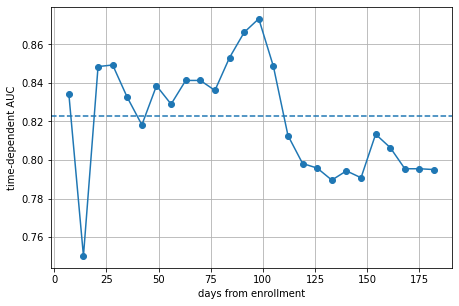

In [11]:
from sksurv.datasets import load_veterans_lung_cancer

va_x, va_y = load_veterans_lung_cancer()

cph = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
cph.fit(va_x, va_y)

va_times = np.arange(7, 183, 7)
# estimate performance on training data, thus use `va_y` twice.
va_auc, va_mean_auc = cumulative_dynamic_auc(va_y, va_y, cph.predict(va_x), va_times)

plt.plot(va_times, va_auc, marker="o")
plt.axhline(va_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

The plot shows that the model is doing quite well on average with an AUC of ~0.82 (dashed line). However, there is a clear difference in performance between the first and second half of the time range. Performance increases up to about 100 days from enrollment, but quickly drops thereafter. Thus, we can conclude that the model is less effective in predicting death past 100 days.

## Conclusion

I hope this notebook helped you to understand some of the pitfalls when estimating the performance of markers and models from right-censored survival data. We illustrated that [Harrell's estimator](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.metrics.concordance_index_censored.html#sksurv.metrics.concordance_index_censored) of the concordance index is biased when the amount of censoring is high, and that [Uno's estimator](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.metrics.concordance_index_ipcw.html#sksurv.metrics.concordance_index_ipcw) is more appropriate in this situation. Finally, we demonstrated that the [time-dependent area under the ROC](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.metrics.cumulative_dynamic_auc.html#sksurv.metrics.cumulative_dynamic_auc) is a very useful tool when we want to predict the occurrence of an event in a period up to time $t$ rather than at a specific time point $t$. 